<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
!pip install gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import requests
import calendar

In [ ]:
url_fire_ev = 'https://data.cityofnewyork.us/resource/8m42-w767.csv?$limit=1000000&$where=incident_datetime>="2017-01-01"%20AND%20INCIDENT_CLASSIFICATION_GROUP="Structural%20Fires"'
fire_ev = pd.read_csv(url_fire_ev)
print(fire_ev.shape)

# if false, then we might not have downloaded all data
print(fire_ev.shape[0])
assert fire_ev.shape[0] < 1000000

(115079, 29)
115079


In [ ]:
fire_ev["incident_date"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.date
fire_ev["incident_month"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.month
fire_ev["incident_day"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.day
fire_ev["incident_year"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.year

fire_ev["incident_md"]= fire_ev[["incident_month", "incident_day"]].astype(str).apply('-'.join, 1)

array(['1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9',
       '1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17',
       '1-18', '1-19', '1-20', '1-21', '1-22', '1-23', '1-24', '1-25',
       '1-26', '1-27', '1-28', '1-29', '1-30', '1-31', '2-1', '2-2',
       '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11',
       '2-12', '2-13', '2-14', '2-15', '2-16', '2-17', '2-18', '2-19',
       '2-20', '2-21', '2-22', '2-23', '2-24', '2-25', '2-26', '2-27',
       '2-28', '3-1', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7', '3-8',
       '3-9', '3-10', '3-11', '3-12', '3-13', '3-14', '3-15', '3-16',
       '3-17', '3-18', '3-19', '3-20', '3-21', '3-22', '3-23', '3-24',
       '3-25', '3-26', '3-27', '3-28', '3-29', '3-30', '3-31', '4-1',
       '4-2', '4-3', '4-4', '4-5', '4-6', '4-7', '4-8', '4-9', '4-10',
       '4-11', '4-12', '4-13', '4-14', '4-15', '4-16', '4-17', '4-18',
       '4-19', '4-20', '4-21', '4-22', '4-23', '4-24', '4-25', '4-26',
       '4-

([<matplotlib.axis.XTick at 0x7f866718c0d0>,
 [Text(0, 0, 'January'),
  Text(0, 0, 'February'),
  Text(0, 0, 'March'),
  Text(0, 0, 'April'),
  Text(0, 0, 'May'),
  Text(0, 0, 'June'),
  Text(0, 0, 'July'),
  Text(0, 0, 'August'),
  Text(0, 0, 'September'),
  Text(0, 0, 'October'),
  Text(0, 0, 'November'),
  Text(0, 0, 'December')])

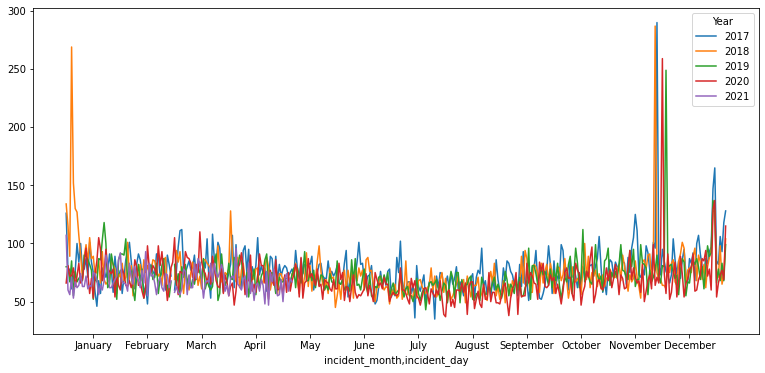

In [ ]:
fire_ev_plt_df= fire_ev.groupby(["incident_year", "incident_month", "incident_day"]).size().unstack(level = 'incident_year')
fire_ev_plt_df.columns.name= "Year"

fig, ax = plt.subplots(figsize=(13, 6))
fire_ev_plt_df.plot(ax = ax)

x = [(x, 15) for x in list(range(1,13))]

plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x is not ''])

In [ ]:
fire_ev

,starfire_incident_id,incident_datetime,alarm_box_borough,alarm_box_number,alarm_box_location,incident_borough,zipcode,policeprecinct,citycouncildistrict,communitydistrict,communityschooldistrict,congressionaldistrict,alarm_source_description_tx,alarm_level_index_description,highest_alarm_level,incident_classification,incident_classification_group,dispatch_response_seconds_qy,first_assignment_datetime,first_activation_datetime,first_on_scene_datetime,incident_close_datetime,valid_dispatch_rspns_time_indc,valid_incident_rspns_time_indc,incident_response_seconds_qy,incident_travel_tm_seconds_qy,engines_assigned_quantity,ladders_assigned_quantity,other_units_assigned_quantity,incident_date,incident_month,incident_day,incident_year,incident_md
0,1700115340110020,2017-01-01T00:14:38.000,MANHATTAN,1534,W 131 ST & LENOX AVE/MALCOLM X BLVD,MANHATTAN,10037.0,32.0,9.0,110.0,5.0,13.0,UCT/911,Initial Alarm,First Alarm,Multiple Dwelling 'A' - Food on the stove fire,Structural Fires,20,2017-01-01T00:14:58.000,2017-01-01T00:15:16.000,2017-01-01T00:18:24.000,2017-01-01T00:25:56.000,N,Y,226,206,3,2,1,2017-01-01,1,1,2017,1-1
1,1700142210120020,2017-01-01T00:26:34.000,BRONX,4221,E TREMONT AVE & WATERBURY AVE,BRONX,10461.0,45.0,13.0,210.0,8.0,14.0,UCT/911,7-5 (All Hands Alarm),Seventh Alarm,Multiple Dwelling 'A' - Other fire,Structural Fires,11,2017-01-01T00:26:45.000,2017-01-01T00:27:03.000,2017-01-01T00:30:06.000,2017-01-01T03:35:00.000,N,Y,212,201,7,5,6,2017-01-01,1,1,2017,1-1
2,1700142210120020,2017-01-01T00:26:34.000,BRONX,4221,E TREMONT AVE & WATERBURY AVE,BRONX,10461.0,45.0,13.0,210.0,8.0,14.0,UCT/911,7-5 (All Hands Alarm),All Hands Working,Multiple Dwelling 'A' - Other fire,Structural Fires,11,2017-01-01T00:26:45.000,2017-01-01T00:27:03.000,2017-01-01T00:30:06.000,2017-01-01T03:35:00.000,N,Y,212,201,7,5,6,2017-01-01,1,1,2017,1-1
3,1700108030140070,2017-01-01T01:01:41.000,BROOKLYN,803,KNICKERBOCKER & GATES AVE,BROOKLYN,11221.0,83.0,37.0,304.0,32.0,7.0,UCT/911,Initial Alarm,First Alarm,School Fire,Structural Fires,7,2017-01-01T01:01:48.000,2017-01-01T01:02:11.000,2017-01-01T01:03:22.000,2017-01-01T01:05:02.000,N,Y,101,94,3,2,1,2017-01-01,1,1,2017,1-1
4,1700129130120060,2017-01-01T01:02:33.000,BRONX,2913,VYSE AVE & E 174 ST,BRONX,10460.0,42.0,17.0,203.0,12.0,15.0,Private Fire Alarm,Initial Alarm,First Alarm,Multiple Dwelling 'A' - Food on the stove fire,Structural Fires,58,2017-01-01T01:03:31.000,2017-01-01T01:03:49.000,2017-01-01T01:07:12.000,2017-01-01T01:29:30.000,N,Y,279,221,1,1,1,2017-01-01,1,1,2017,1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115074,2112560000000000,2021-05-05T21:28:00.000,QUEENS,6117,CORBETT RD & 221 ST,QUEENS,11361.0,111.0,19.0,411.0,26.0,6.0,Private Fire Alarm,Initial Alarm,First Alarm,Private Dwelling Fire,Structural Fires,55,2021-05-05T21:29:00.000,2021-05-05T21:29:00.000,2021-05-05T21:34:00.000,2021-05-05T21:41:00.000,N,Y,319,264,1,1,0,2021-05-05,5,5,2021,5-5
115075,2112510000000000,2021-05-05T21:31:00.000,MANHATTAN,1442,LEXINGTON AVE & 121 ST,MANHATTAN,10035.0,25.0,9.0,111.0,4.0,13.0,Phone,Initial Alarm,First Alarm,Multiple Dwelling 'A' - Other fire,Structural Fires,25,2021-05-05T21:31:00.000,2021-05-05T21:31:00.000,2021-05-05T21:33:00.000,2021-05-05T22:48:00.000,N,Y,151,126,4,2,1,2021-05-05,5,5,2021,5-5
115076,2112510000000000,2021-05-05T22:23:00.000,MANHATTAN,1325,AMSTERDAM AVE & 109 ST,MANHATTAN,10025.0,24.0,7.0,107.0,3.0,10.0,Phone,Initial Alarm,First Alarm,Multiple Dwelling 'A' - Food on the stove fire,Structural Fires,26,2021-05-05T22:24:00.000,2021-05-05T22:24:00.000,2021-05-05T22:27:00.000,2021-05-05T22:41:00.000,N,Y,210,184,3,2,1,2021-05-05,5,5,2021,5-5
115077,2112530000000000,2021-05-05T23:16:00.000,BRONX,3170,BRYANT AVE & BRONX PARK SO.,BRONX,10460.0,48.0,15.0,206.0,12.0,15.0,Phone,Initial Alarm,First Alarm,Multiple Dwelling 'A' - Other fire,Structural Fires,34,2021-05-05T23:17:00.000,2021-05-05T23:17:00